In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import scipy.stats as stats

df = pd.read_csv('data/human_body_temperature.csv')

## Prior to working through the questions, EDA of the data sample

In [2]:
df.info()
print(df.gender.value_counts())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB
M    65
F    65
Name: gender, dtype: int64
   temperature gender  heart_rate
0         99.3      F        68.0
1         98.4      F        81.0
2         97.8      M        73.0
3         99.2      F        66.0
4         98.0      F        73.0


In [3]:
df.describe()

,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


In [4]:
print('The difference in mean temperature and 98.6 degrees fahrenheit is: ' + str(98.6 - np.mean(df.temperature)))

The difference in mean temperature and 98.6 degrees fahrenheit is: 0.35076923076921673


#### Looking at the distribution of Temperature and Heart Rate by histogram, swarm plot included to avoid binning bias

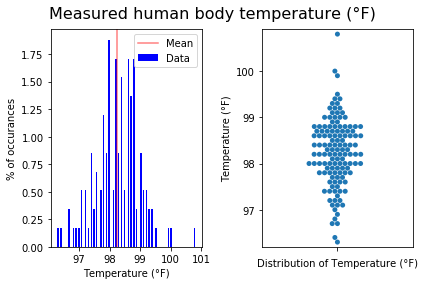

In [5]:
# Histogram of human body temperature
plt.subplot(1,2,1)
plt.hist(df.temperature, bins = 100, normed=True, label='Data', color='blue')
plt.axvline(np.mean(df.temperature), label = 'Mean', linestyle='-', color='red', alpha=.5)
plt.legend(loc='upper right')
plt.xlabel('Temperature (°F)')
plt.ylabel('% of occurances')

# Swarmplot of human body temperature
plt.subplot(1,2,2)
sns.swarmplot(y='temperature', data=df)
plt.xlabel('Distribution of Temperature (°F)')
plt.ylabel('Temperature (°F)')

plt.suptitle('Measured human body temperature (°F)', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.margins(.02)
plt.show()

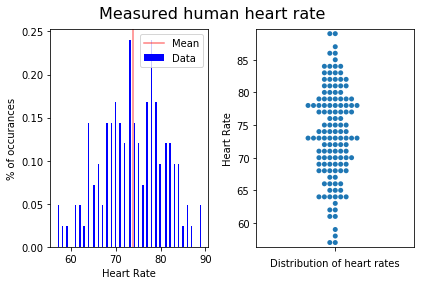

In [6]:
# Histogram
plt.subplot(1,2,1)
plt.hist(df.heart_rate, bins = 100, normed=True, label='Data', color='blue')
plt.axvline(np.mean(df.heart_rate), label = 'Mean', linestyle='-', color='red', alpha=.5)
plt.legend(loc='upper right')
plt.xlabel('Heart Rate')
plt.ylabel('% of occurances')

# Swarm plot
plt.subplot(1,2,2)
sns.swarmplot(y='heart_rate', data=df)
plt.xlabel('Distribution of heart rates')
plt.ylabel('Heart Rate')

plt.suptitle('Measured human heart rate', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.margins(.02)
plt.show()

#### Computing the covariance matrix and pearson coefficient

In [7]:
# Compute the covariance matrix: covariance_matrix
covariance_matrix = np.cov(df.heart_rate, df.temperature)

# Print covariance matrix
print(covariance_matrix)

# Extract covariance of heart rate and temperature of human body: hr_temp_cov
hr_temp_cov = covariance_matrix[0,1]

print(hr_temp_cov)

[[49.87292785  1.31338104]
 [ 1.31338104  0.53755754]]
1.3133810375670796


In [8]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix & return entry [0,1]
    return np.corrcoef(x, y)[0,1]

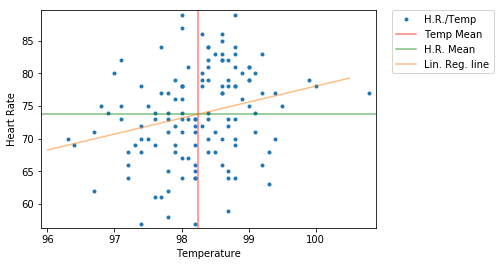

The Pearson coefficient is: 0.2536564027207642
slope = 2.443238038611887 : Heart Rate / Temperature
intercept = -166.2847194182036


In [9]:
plt.plot(df.temperature, df.heart_rate, marker='.', label = 'H.R./Temp', linestyle='none')

# Add mean lines for temperature and heart rate
plt.axvline(np.mean(df.temperature), linestyle='-', label='Temp Mean', color='red', alpha=.5)
plt.axhline(np.mean(df.heart_rate), linestyle='-', label='H.R. Mean', color='green', alpha=.5)

# Perform a linear regression using np.polyfit(): a, b
a, b = np.polyfit(df.temperature,df.heart_rate,1)

# Make theoretical line to plot
x = np.array([96,100.5])
y = a * x + b

# Add regression line to your plot
plt.plot(x, y, label='Lin. Reg. line', alpha=.5)

plt.xlabel('Temperature')
plt.ylabel('Heart Rate')
plt.margins(.02)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

print('The Pearson coefficient is: ' + str(pearson_r(df.heart_rate, df.temperature)))
print('slope =', a, ': Heart Rate / Temperature')
print('intercept =', b)

In [10]:
# Compute observed correlation: r_obs
r_obs = pearson_r(df.heart_rate, df.temperature)

# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(100000)

# Draw replicates
for i in range(100000):
    # Permute heart rate measurments: hr_permuted
    hr_permuted = np.random.permutation(df.heart_rate)

    # Compute Pearson correlation
    perm_replicates[i] = pearson_r(hr_permuted, df.temperature)

# Compute p-value: p
p = np.sum(perm_replicates >= r_obs) / len(perm_replicates)
print('p-val =', p)

p-val = 0.00182


The low p-value that we're showing here demonstrates that it's not just chance that heart rate and temperature have a low pearson coefficient.

*Looking at the scatter plot shows that the collected data of temperature and heart rate a linear relationship. The Pearson coefficient is a positive 0.254. In our further analysis of temperatures, heart rate won't be a strong predictor of temperature. However, the positive correlation of 0.25 could warrent further investigation of how temperature affects heart rates (cases of hypo/hyper thermia). Regression analysis with heart rate as the dependent variable gives the equation:*

Heart Rate = 2.443 x Temperature - 166.285.

*"Note that the Pearson correlation reflects the non-linearity and direction of a linear relationship". [1]*
[1]: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

### 1. Is the distribution of body temperatures normal? 

We've already look at the distribution of the Human body temperature data as a histogram. To help determine if the data is normally distributed we'll also graph the Cumulative Distribution Function (CDF).

In [11]:
'''Function call to compute the Empirical Cumulative Distribution Function (ECDF)'''
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    #Returns a coordinate set of the data: x, y
    return np.sort(data), np.arange(1, len(data) + 1) / len(data)

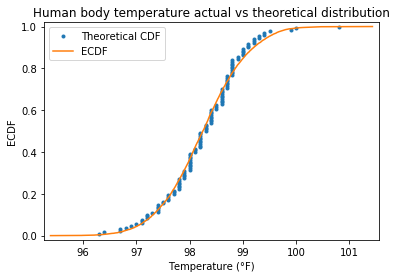

In [12]:
# calculating the cdf from the empirical data set
x_temp, y_temp = ecdf(df.temperature)
plt.plot(x_temp, y_temp, marker='.', linestyle='none')

# calculating a theoretical normal distribution from the mean and std. dev. of the empirical temperature data
theo_dist = np.random.normal(np.mean(df.temperature), np.std(df.temperature), size=10000)
x_theo_temp, y_theo_temp = ecdf(theo_dist)


plt.plot(x_theo_temp,y_theo_temp)
plt.title('Human body temperature actual vs theoretical distribution')
plt.ylabel('ECDF')
plt.xlabel('Temperature (°F)')
plt.margins(.02)
plt.legend(('Theoretical CDF','ECDF'))
plt.show()

We have the ECDF and theoretical CDF comparison to assist in identifying if our temperature data set is normal. From this graph we can see that:

**The distribution of the data is normal**

As an additional measure of certainty, we'll use bootstrapping on the sample to increase the number observations then see if this larger sample size does show a normal distribution.

In [13]:
# This function will allow us to take our data and increase the number of our observations.

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, len(data)))

    return bs_replicates

The standard error of the mean of the original data is: 0.06405661469519336
The standard error of the mean of our bootstrapped data is: 0.06386207018839428


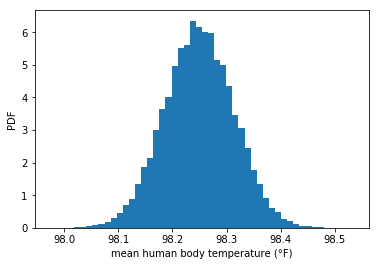

There is a 95% chance a data point would fall between [98.12384615 98.37384615]
The difference between the 2.5%, 50%, 97.5% percentiles are:  [0.12541721] [0.12458279]
This shows that we have symmetry, normal distribution


In [14]:
# Take 100,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(df.temperature, np.mean, 100000)

# Compute and print SEM
sem = np.std(df.temperature) / np.sqrt(len(df.temperature))
print('The standard error of the mean of the original data is: ' + str(sem))

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print('The standard error of the mean of our bootstrapped data is: ' + str(bs_std))

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel('mean human body temperature (°F)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

print('There is a 95% chance a data point would fall between', np.percentile(bs_replicates, [2.5, 97.5]))
print('The difference between the 2.5%, 50%, 97.5% percentiles are: ',\
     np.mean(bs_replicates) - np.percentile(bs_replicates, [2.5]),\
     np.percentile(bs_replicates, [97.5]) - np.mean(bs_replicates))
print('This shows that we have symmetry, normal distribution')

This is a probabilistic estimate of the mean human body temperature. The distribution of this data is normal. The SEM for our original data set and bootstrapped data set are near identical. 

When taken in context with the ECDF and CDF comparison, we can safely say that **the distribution of our Human body temperature is normal**.

*The standard deviation of this distribution, called the standard error of the mean, or SEM, is given by the standard deviation of the data divided by the square root of the number of data points. *

## 2. Is the sample size large? Are the observations independent?
* Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply. 

**The sample size for the human body temperature data consists of 130 observations as such the sample is large.**
* 65 observations with female (F) classification
* 65 observations with male (M) classification. We have a sufficiently large sample size

_Proof for assertion:_

"A 95% degree confidence corresponds to $\alpha$ = 0.05. Each of the shaded tails in the following figure has an area of $\alpha$/2 = 0.025. The region to the left of $z_\alpha/_2$ and to the right of z = 0 is 0.5 – 0.025, or 0.475. In the table of the standard normal (z) distribution, an area of 0.475 corresponds to a z value of 1.96. The critical value is therefore = 1.96" [2]. For a 99% degree of confidence we have a critical value of 2.58

To find our necessary n sample size, we can solve

n = ((critical value * Std. Dev. of sample) / (Abs. value of observed sample mean - population mean)) ^ 2

In our instance the calculations for 95% and 99% from z-values are:

17 (approx.) = ( (1.96 * .733) / (|98.25 - 98.6|) )^2

29 (approx) = ( (2.58 * .733) / (|98.25 - 98.6|) )^2

From this we can say for a 95% degree of confidence, we'd need a sample of at least 17. For a 99% degree of confidence we'd require at least 29 samples. Using T-score table values, our approximate N for those degrees of confidence are at least 17, and 30.

[2]: https://www.isixsigma.com/tools-templates/sampling-data/how-determine-sample-size-determining-sample-size/

**The observations are independent:**
* Independence Assumption: The sample values must be independent of each other. This means that the occurrence of one event has no influence on the next event. Usually, if we know that people or items were selected randomly we can assume that the independence assumption is met.
* "The authors display a histogram of 148 subjects' normal temperatures taken at several different times during two consecutive days, resulting in 700 total readings. The relative frequency histogram is also broken down by gender (122 males and 26 females). \[The dataset creator\] derived the dataset presented here by working backwards from this histogram. \[The dataset creator\] tried as closely as possible to recreate the original data, but with a reduction in sample size to 130 total readings" http://ww2.amstat.org/publications/jse/v4n2/datasets.shoemaker.html
    * From this knowledge we can assume that the independence assumption is met.

## 3. Is the true population mean really 98.6 degrees F?

* Try a bootstrap hypothesis test.
* Try frequentist statistical testing. 
    * One-sample or two-sample test? Why?
    * Is it appropriate to use the tt or zz statistic?
    * Try using the other test. How is the result be different? Why? 

#### Our first approach will be the bootstrap hypothesis test:

$H_0$: The mean of the data sample ($\mu$) is 98.6°F ($\mu_0$), $\mu$ = $\mu_0$. $\alpha$ = 0.05

$H_A$: The mean of the data sample is not 98.6°F. $\mu\neq\mu_0$.

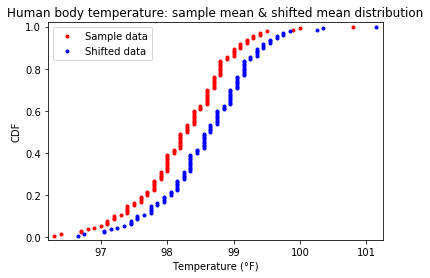

In [15]:
# Shifting the sample mean to 98.6
sample_mean_shifted = df.temperature - np.mean(df.temperature) + 98.6

# calculating, plotting the cdf of the sample data, vert. mean line
x_data, y_data = ecdf(df.temperature)
plt.plot(x_data, y_data, marker='.', linestyle='none', label='Sample data', color='red')
#plt.axvline(np.mean(df.temperature), linestyle='-', label='Sample mean', color='red', alpha=.5)

# calculating, plotting the cdf of the shifted mean data, vert. mean line
x_shift, y_shift = ecdf(sample_mean_shifted)
plt.plot(x_shift, y_shift, marker='.', linestyle='none', label='Shifted data', color='blue')
#plt.axvline(np.mean(sample_mean_shifted), linestyle='-', label='Shifted mean', color='blue', alpha=.5)

plt.title('Human body temperature: sample mean & shifted mean distribution')
plt.ylabel('CDF')
plt.xlabel('Temperature (°F)')
plt.margins(.02)
plt.legend()
plt.show()

In [16]:
# This will also be used to calculate our t_test numerator
def diff_pop_mean(data, pop_mean=98.6): #TPM defaulted to 98.6
    '''Will take an input, calculate its mean, compute and return the difference from TPM'''
    return np.mean(data) - pop_mean

diff_obs = diff_pop_mean(df.temperature)

print('The difference of our sample mean and the pop. mean is: ', f'{diff_obs:.5f}')

The difference of our sample mean and the pop. mean is:  -0.35077


In [17]:
bs_shifted_mean = draw_bs_reps(sample_mean_shifted, diff_pop_mean, 100000)
# value of our test statistic computed from a bootstrap sample

p_value = np.sum(bs_shifted_mean >= 98.6) / len(bs_shifted_mean)
print('The probability, p-value, that we would get a value of 98.6°F or more extreme is:', f'{p_value:.6f}')

The probability, p-value, that we would get a value of 98.6°F or more extreme is: 0.000000


**Our second approach will be to use a one sample approach. We'll use this because we're comparing our sample (hypothesis) mean to a population mean (of 98.6)**

We'll start by using the t-test:

_t-value = (sample mean - population mean) / (sample standard deviation / square root of sample size)_

_z-value = (sample mean - population mean) / population standard deviation_

The population standard deviation can be approximated by sample standard deviation / square root of sample size. Due to this we'll use the original t-value also as our z-value

In [18]:
'''Calculates t-statistic'''
def t_test(data, pop_mean=98.6) :
    return diff_pop_mean(data, pop_mean) / (data.std(ddof=1) / np.sqrt(len(data)))

deg_free = len(df.temperature) - 1 # degrees of freedom = (n-1)
t_val = t_test(df.temperature)
pt_val = 2*(stats.t.sf(abs(t_val), deg_free))
print('The t-value is: ', t_test(df.temperature))
print('with: ', deg_free, ' degrees of freedom')
print('The p-value is: ', f'{pt_val:.9f}') 

The t-value is:  -5.454823292364079
with:  129  degrees of freedom
The p-value is:  0.000000241


In [19]:
print('Our p-value, ', f'{pt_val:.9f}', ' needs to be equal or greater than our alpha, 0.05.')
print('Assuming the Pop. mean is 98.6, this result could be observed in approximately', f'{pt_val:.9f}', '% of samples')
print('Our null hypothesis is probabalistically false')

Our p-value,  0.000000241  needs to be equal or greater than our alpha, 0.05.
Assuming the Pop. mean is 98.6, this result could be observed in approximately 0.000000241 % of samples
Our null hypothesis is probabalistically false


**Our null hypothesis from our t-values is probabalistically false, This is shown visually below**

A t-value of -5.45 means that we're 5.45 standard deviations below/left of our 98.6°F population mean ($\mu_0$).
The area under the curve is represented in our p-value

The probability, p-value, that is shown by the red, t-val line is:  0.0000002411
The values we'd need for 95%, and 99% confidence are shown in orange and purple


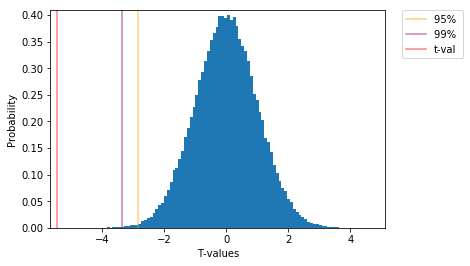

In [20]:
plt.hist(np.random.standard_t(deg_free, size=100000), bins=100, normed=True)

plt.axvline(-2.8561, linestyle='-', label='95% ', color='orange', alpha=.5)
plt.axvline(-3.3676, linestyle='-', label='99% ', color='purple', alpha=.5)
plt.axvline(t_val, linestyle='-', label='t-val', color='red', alpha=.5)

plt.xlabel('T-values')
plt.ylabel('Probability')
plt.margins(.02)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot()

print('The probability, p-value, that is shown by the red, t-val line is: ', f'{pt_val:.10f}')
print('The values we\'d need for 95%, and 99% confidence are shown in orange and purple')

**We'll conclude by using a zz statistic to analyze our sample, and compare them with our tt statistic results**

In [21]:
z_val = t_val
pz_val = 2 * stats.norm.sf(abs(z_val))

print('The z-value is: ', z_val)
print('The p-value is: ', f'{pz_val:.10f}')

The z-value is:  -5.454823292364079
The p-value is:  0.0000000490


In [22]:
print('Our p-value, ', pz_val, ' needs to be equal or greater than our alpha, 0.05.')
print('Assuming the Pop. mean is 98.6, this result could be observed in approximately', f'{pz_val:.10f}', '% of samples')
print('Our null hypothesis is probabalistically false')

Our p-value,  4.90215701411338e-08  needs to be equal or greater than our alpha, 0.05.
Assuming the Pop. mean is 98.6, this result could be observed in approximately 0.0000000490 % of samples
Our null hypothesis is probabalistically false


**Our null hypothesis from our z-values is probabalistically false, This is shown visually below**

A z-value of -5.45 means that we're 5.45 standard deviations below/left of our 98.6°F population mean ($\mu_0$).
The area under the curve is represented in our p-value

The probability, p-value, that is shown by the red, result z-val line is:  0.0000000490
The values we'd need for 95%, and 99% confidence are shown in orange and purple


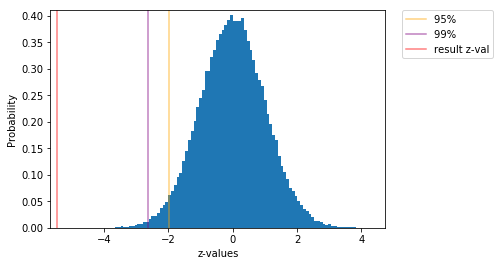

In [23]:
plt.hist(np.random.standard_t(deg_free, size=100000), bins=100, normed=True) # Is this the right distribution model?

plt.axvline(-1.98, linestyle='-', label='95% ', color='orange', alpha=.5)
plt.axvline(-2.62, linestyle='-', label='99% ', color='purple', alpha=.5)
plt.axvline(z_val, linestyle='-', label='result z-val', color='red', alpha=.5)

plt.xlabel('z-values')
plt.ylabel('Probability')
plt.margins(.02)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot()

print('The probability, p-value, that is shown by the red, result z-val line is: ', f'{pz_val:.10f}')
print('The values we\'d need for 95%, and 99% confidence are shown in orange and purple')

**We can probabalistically reject $H_0$: $\mu$ = $\mu_0$**

Our results from bootstrapping, t-values, and z-values all probabilistically show that the alternate hypothesis: $H_A$: The mean of the data sample is not 98.6°F. $\mu\neq\mu_0$, is probabilistically true.

While our t-value and z-value are the same, their p-values differ.

In [24]:
print(f'{pt_val:.10f}')
print(f'{pz_val:.10f}')
print('Their difference is ', f'{pt_val-pz_val:.9f}')

0.0000002411
0.0000000490
Their difference is  0.000000192


**How is the result be different? Why? **

The difference stems from the different critical values between t-values and z-values for looking up p-values. In this instance, while different, they still prove, by statistical probability, the null hypothesis is false

## 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.
* Which one is the correct one to use?
* What do you notice? What does this tell you about the difference in application of the tt and zz statistic? 

In [25]:
'''Drawing the 10 value sample size from temperature data'''
sample_10 = np.random.choice(df.temperature, size=10)
sample_10

array([98.3, 99.1, 98.5, 99.1, 98.1, 98.6, 98. , 97.5, 98. , 98.2])

**T-test with 10 observations from our sample**

In [26]:
deg_free = len(sample_10) - 1 # degrees of freedom = (n-1)
t_10 = t_test(sample_10)
pt_10 = 2*(stats.t.sf(abs(t_10), deg_free))

print('The t-value is: ', t_10)
print('with: ', deg_free, ' degrees of freedom')
print('The p-value is: ', pt_10) 

The t-value is:  -1.6392922716658236
with:  9  degrees of freedom
The p-value is:  0.1355744549441428


In [27]:
print('Our p-value, ', pt_10, ' needs to be equal or greater than our alpha, 0.05.')
if pt_10 < 0.05 : 
    print('Assuming the Pop. mean is 98.6, this result could be observed in approximately', f'{pt_10:.5f}', '% of samples')
    print('Our null hypothesis is probabalistically false')
else : print('Our null hypothesis is probabalistically true')

Our p-value,  0.1355744549441428  needs to be equal or greater than our alpha, 0.05.
Our null hypothesis is probabalistically true


The probability, p-value, that is shown by the red, result t-val line is:  0.13557
The values we'd need for 95%, and 99% confidence are shown in orange and purple


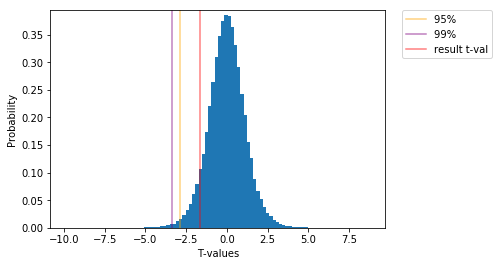

In [28]:
plt.hist(np.random.standard_t(deg_free, size=100000), bins=100, normed=True)

plt.axvline(-2.8561,  linestyle='-', label='95% ', color='orange', alpha=.5)
plt.axvline(-3.3676, linestyle='-', label='99% ', color='purple', alpha=.5)
plt.axvline(t_10, linestyle='-', label='result t-val', color='red', alpha=.5)

plt.xlabel('T-values')
plt.ylabel('Probability')
plt.margins(.02)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot()

print('The probability, p-value, that is shown by the red, result t-val line is: ', f'{pt_10:.5f}')
print('The values we\'d need for 95%, and 99% confidence are shown in orange and purple')

**Z-test with 10 observations from our sample**

In [29]:
z_10 = t_10
pz_10 = 2 * stats.norm.sf(abs(z_10))

print('The z-value is: ', z_10)
print('The p-value is: ', pz_10)

The z-value is:  -1.6392922716658236
The p-value is:  0.10115240479262586


The probability, p-value, that is shown by the red, result t-val line is:  0.10115
The values we'd need for 95%, and 99% confidence are shown in orange and purple


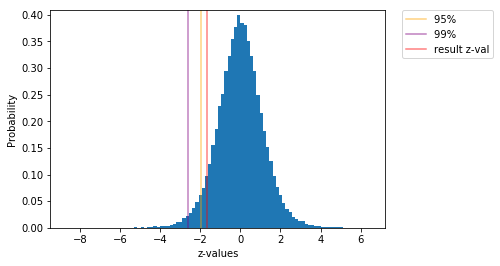

In [30]:
plt.hist(np.random.standard_t(deg_free, size=100000), bins=100, normed=True)

plt.axvline(-1.98, linestyle='-', label='95% ', color='orange', alpha=.5)
plt.axvline(-2.62, linestyle='-', label='99% ', color='purple', alpha=.5)
plt.axvline(z_10, linestyle='-', label='result z-val', color='red', alpha=.5)

plt.xlabel('z-values')
plt.ylabel('Probability')
plt.margins(.02)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot()

print('The probability, p-value, that is shown by the red, result t-val line is: ', f'{pz_10:.5f}')
print('The values we\'d need for 95%, and 99% confidence are shown in orange and purple')

**Due to the sample being limited to below our critical N values for z-testing that we proved above, a t-test would be more appropriate in this 10 sample test**

## 5. At what temperature should we consider someone's temperature to be "abnormal"?

1. Start by computing the margin of error and confidence interval. 
    * When calculating the confidence interval, **keep in mind that you should use the appropriate formula for one draw, and not N draws.**
2. Try calculating everything using the boostrap approach
3. Try using the frequentist approach.

**The first step, and second, was done previously when looking at the normal distributions, the results were as follows:**

In [86]:
moe = 1.96 * np.std(df.temperature) / np.sqrt(len(df.temperature))
print(moe)
print('The confidence interval is between', np.percentile(bs_replicates, [2.5, 97.5]))

0.125550964802579
The confidence interval is between [98.12384615 98.37384615]


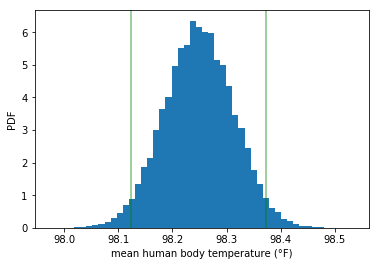

In [32]:
# Make a histogram of the results
plt.hist(bs_replicates, bins=50, normed=True)
plt.xlabel('mean human body temperature (°F)')
plt.ylabel('PDF')

plt.axvline(np.percentile(bs_replicates, [2.5]), linestyle='-', label='2.5% ', color='green', alpha=.5)
plt.axvline(np.percentile(bs_replicates, [97.5]), linestyle='-', label='99% ', color='green', alpha=.5)

plt.show()

In [95]:
# Prediction Interval
pi = 1.96 * np.std(df.temperature) * np.sqrt(1 + 1/len(df.temperature))
print(f'{pi:.10f}')

mean = np.mean(df.temperature)

pi_int = np.mean(df.temperature) + np.array([-1,1]) * pi
pi_int

1.4369964732


array([96.8122343 , 99.68622724])

The range of temps that we would consider to be abnormal are anything below 96.81, and above 99.69 degr

Text(0,0.5,'Distribution of Temps')

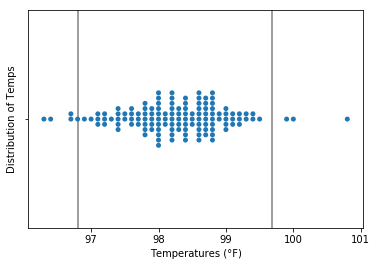

In [68]:
sns.swarmplot(x='temperature', data=df)
plt.axvline(pi_int[0], linestyle='-', color='black', alpha=.5)
plt.axvline(pi_int[1], linestyle='-', color='black', alpha=.5)

plt.xlabel('Temperatures (°F)')
plt.ylabel('Distribution of Temps')

 ## 6. Is there a significant difference between males and females in normal temperature?
        What testing approach did you use and why?
        Write a story with your conclusion in the context of the original problem. 



$H_0$: The mean female human body temperature ($\mu$) and male human body temperature ($\mu_0$) are the same, $\mu$ = $\mu_0$. $\alpha$ = 0.05

$H_A$: The means of the two data sets are not equal. $\mu\neq\mu_0$.

### **Graphical EDA of temperature by gender**

In [76]:
female_temp = df.temperature[df['gender']=='F']
male_temp = df.temperature[df['gender']=='M']

emp_mean_diff = diff_of_means(female_temp, male_temp)
print('difference of means =', emp_mean_diff, '(°F)')

difference of means = 0.289230769230727 (°F)


Is there a difference in temperature between females and males? Yes, approximately 0.289°F.

In [77]:
# Get bootstrap replicates of means
bs_replicates_female = draw_bs_reps(female_temp, np.mean, 10000)
bs_replicates_male = draw_bs_reps(male_temp, np.mean, 10000)

#### Swarmplot

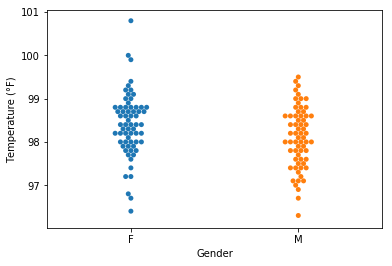

In [69]:
_ = sns.swarmplot(x='gender', y='temperature', data=df)
_ = plt.xlabel('Gender')
_ = plt.ylabel('Temperature (°F)')
plt.show()

#### PDF Histogram of Gender Temperature Mean

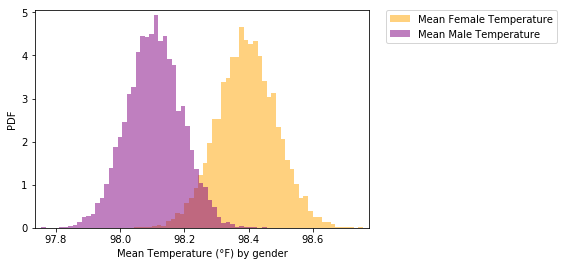

In [78]:
_ = plt.hist(bs_replicates_female, bins=50, normed=True, alpha=.5, label = 'Mean Female Temperature', color='orange')
_ = plt.hist(bs_replicates_male, bins=50, normed=True, alpha=.5, label = 'Mean Male Temperature', color='purple')
plt.xlabel('Mean Temperature (°F) by gender')
plt.ylabel('PDF')
plt.margins(.02)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Show the plot
plt.show()

#### ECDF by Gender Temperature Mean

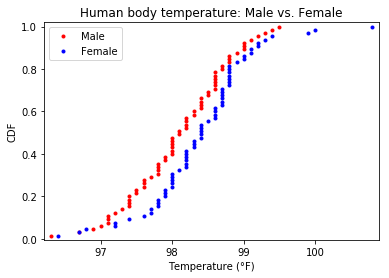

In [79]:
male_x, male_y = ecdf(male_temp)
fmale_x, fmale_y = ecdf(female_temp)

plt.plot(male_x, male_y, marker='.', linestyle='none', color='red')
plt.plot(fmale_x, fmale_y, marker='.', linestyle='none', color='blue')
plt.title('Human body temperature: Male vs. Female')
plt.ylabel('CDF')
plt.xlabel('Temperature (°F)')
plt.margins(.02)
plt.legend(('Male','Female'))
plt.show()

**Our first testing approach will be to use a shifted mean bootstrapped approach**

In [80]:
# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = diff_of_means(bs_replicates_female, bs_replicates_male)

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates,[2.5,97.5])
print('95% confidence interval =', conf_int, '(°F)')

95% confidence interval = [0.28764292 0.28764292] (°F)


In [81]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(df.temperature)

# Shift the samples
bd_female_shifted = female_temp - np.mean(female_temp) + combined_mean
bd_male_shifted = male_temp - np.mean(male_temp) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_female = draw_bs_reps(bd_female_shifted, np.mean, 10000)
bs_replicates_male = draw_bs_reps(bd_male_shifted, np.mean, 10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_male - bs_replicates_female

# Compute the p-value
p = np.sum(bs_diff_replicates >= emp_mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)


p = 0.0097


In [ ]:
print('Our p-value, ', p, ' needs to be equal or greater than our alpha, 0.05.')
if p < 0.05 : 
    print('Assuming the means are equal, this result could be observed in approximately', f'{p:.4f}', '% of samples')
    print('Our null hypothesis is probabalistically false')
else : print('Our null hypothesis is probabalistically true')

**Our second approach will be using a two-sample z-test to find p-value**

In [89]:
# Standard Error
stan_err = np.sqrt((np.std(female_temp)**2) / len(female_temp) + (np.std(male_temp)**2) / len(male_temp))
print(f'{stan_err:.10f}')

moe = 1.96 * stan_err # Margin of Error
print(f'{moe:.10f}')

0.1255766852
0.2461303030


In [90]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
    return np.mean(data_1) - np.mean(data_2)

In [ ]:
numerator = diff_of_means(female_temp, male_temp) #x1bar - x2bar - delta (0)
z = numerator / stan_err # Standard Error == denominator
pval = stats.norm.cdf(-z) * 2 # Why am I using -z?
print('Z score: ', f'{z:.5f}')
print('P-value: ', f'{pval:.7f}')

In [ ]:
plt.hist(np.random.standard_t(deg_free, size=100000), bins=100, normed=True)

plt.axvline(1.98, linestyle='-', label='95% ', color='orange', alpha=.5)
plt.axvline(2.62, linestyle='-', label='99% ', color='purple', alpha=.5)
plt.axvline(z, linestyle='-', label='result z-val', color='red', alpha=.5)

plt.xlabel('z-values')
plt.ylabel('Probability')
plt.margins(.02)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot()

print('The probability, p-value:',f'{pval:.7f}', 'that is shown by the red, result z-val line is: ', f'{z:.10f}')
print('The values we\'d need for 95%, and 99% confidence are shown in orange and purple')

In [ ]:
print('Our p-value, ', pval, ' needs to be equal or greater than our alpha, 0.025.')
if pval < 0.025 : 
    print('Assuming the means are equal, this result could be observed in approximately', f'{p:.4f}', '% of samples')
    print('Our null hypothesis is probabalistically false')
else : print('Our null hypothesis is probabalistically true')

**There is a difference between the mean temperatures of males and females in the sample by approx. 0.289°F. Our confidence level is between the 95% and 99% levels. This shows statistical significance in the difference between our samples. However, we want to avoid a publication bias/type I error that because we reached at least 95% there is a true difference between genders in the population. There may also be sampling**

## Final summary and conclusion
